# Setup

In [ ]:
!pip install -U tensorflow-addons
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import gdown

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# gdown 5 fold

In [ ]:
# load fold1
!gdown 1m6zm1FNZO4doAVOxaWIJ6H69RHrBmobV
!unzip fold_data\ 1.zip
!rm -r fold_data\ 1.zip

In [ ]:
# load fold 2
!gdown 1PB0tDlPJUzefhucO-Ohjx5xDPVNrtLOS
!unzip fold_data\ 2.zip
!rm -r fold_data\ 2.zip

In [ ]:
# load fold 3
!gdown 1pGOpWyKlQh1Kk1KQ-c44gEjqwa4xWpGI
!unzip fold_data\ 3.zip
!rm -r fold_data\ 3.zip

In [ ]:
# load fold 4
!gdown 1_TXDt9NlgvpmjCLd-YqataIu8SbFYRp2
!unzip fold_data\ 4.zip
!rm -r fold_data\ 4.zip

In [ ]:
# load fold 5
!gdown 1NICWJ8bPP1C1j5ryQPRQG5jxuvniuGVz
!unzip fold_data\ 5.zip
!rm -r fold_data\ 5.zip

# load data

In [ ]:
import tensorflow as tf
import numpy as np

# change fold here
train_path = 'fold_data 5/train'
test_path = 'fold_data 5/test'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='binary',
    validation_split=None,
    subset=None,
    seed=123,
    image_size=(32, 32),
    batch_size=16)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='binary',
    validation_split=None,
    subset=None,
    seed=123,
    image_size=(32,32),
    batch_size=16)

x_train, y_train = next(iter(train_ds))
x_test, y_test = next(iter(test_ds))
print("--------------------------------")
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

Found 301 files belonging to 2 classes.
Found 33 files belonging to 2 classes.
--------------------------------
x_train shape: (16, 32, 32, 3) - y_train shape: (16, 1)
x_test shape: (16, 32, 32, 3) - y_test shape: (16, 1)


# Configure the hyperparameters

In [ ]:
num_classes = 1
input_shape = (32, 32, 3)

In [ ]:
learning_rate = 3e-4
weight_decay = 0.0001
batch_size = 16
num_epochs = 30
image_size = 32  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 2
mlp_head_units = [1024, 64]  # Size of the dense layers of the final classifier

# Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

# Model creation


In [ ]:
# Implement multilayer perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
# Implement patch creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 32 X 32
Patch size: 16 X 16
Patches per image: 4
Elements per patch: 768


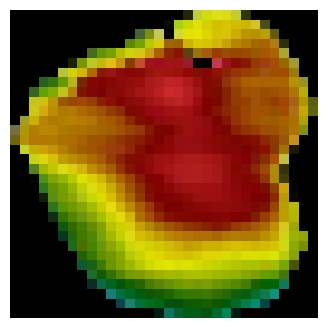

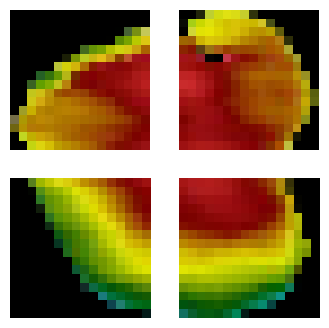

In [ ]:
# display patches for a sample image
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
image_uint8 = tf.cast(image, dtype=tf.uint8)
plt.imshow(image_uint8)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Implement the patch encoding layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
# Build the ViT model
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    # Classify outputs.
    logits = layers.Dense(num_classes, activation='sigmoid')(features)
    # logits = layers.Dense(num_classes)(features)

    # x1 = keras.layers.Dense(num_classes, activation='sigmoid')(features)
    # added = keras.layers.Add()([x1])
    # out = tf.keras.layers.Dense(num_classes)(added)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs= logits)
    return model

# Compile and train the model

In [ ]:
from keras import backend as K
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[
           keras.metrics.BinaryAccuracy(name = 'accuracy'),
           get_f1
        ],
    )

    checkpoint_filepath = "/content/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    loss, accuracy,f1_score = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {accuracy * 100}%")
    print(f"Test loss: {loss}")
    print(f"Test f1 score: {f1_score}")
    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/30
1/1 [==============================] - 5s 5s/step - loss: 0.9574 - accuracy: 0.4286 - get_f1: 0.5000 - val_loss: 0.5042 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 2/30
1/1 [==============================] - 0s 55ms/step - loss: 0.5730 - accuracy: 0.6429 - get_f1: 0.7368 - val_loss: 0.3709 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 3/30
1/1 [==============================] - 0s 59ms/step - loss: 0.8190 - accuracy: 0.6429 - get_f1: 0.7368 - val_loss: 0.2728 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 4/30
1/1 [==============================] - 0s 55ms/step - loss: 0.6807 - accuracy: 0.6429 - get_f1: 0.7619 - val_loss: 0.2061 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 5/30
1/1 [==============================] - 0s 48ms/step - loss: 0.5387 - accuracy: 0.7143 - get_f1: 0.8182 - val_loss: 0.1583 - val_accuracy: 1.0000 - val_get_f1: 1.0000
Epoch 6/30
1/1 [==============================] - 0s 53ms/step - loss: 0.4570 - accuracy: 0.7857 - get_f1: 0.8696 - v

In [ ]:
history.history

{'loss': [0.9573556184768677,
  0.5729662775993347,
  0.8189656138420105,
  0.6807164549827576,
  0.5387225151062012,
  0.456985205411911,
  0.619021475315094,
  0.384606271982193,
  0.4657551944255829,
  0.34663769602775574,
  0.5754057168960571,
  0.3837154507637024,
  0.22584107518196106,
  0.32183927297592163,
  0.25465065240859985,
  0.3658832907676697,
  0.1848885715007782,
  0.23677070438861847,
  0.2878871560096741,
  0.29179054498672485,
  0.25265589356422424,
  0.16931697726249695,
  0.05459631234407425,
  0.2252732664346695,
  0.0755179151892662,
  0.08693276345729828,
  0.20747654139995575,
  0.1498268097639084,
  0.2705492079257965,
  0.210038423538208],
 'accuracy': [0.4285714328289032,
  0.6428571343421936,
  0.6428571343421936,
  0.6428571343421936,
  0.7142857313156128,
  0.7857142686843872,
  0.7142857313156128,
  0.7857142686843872,
  0.6428571343421936,
  0.8571428656578064,
  0.6428571343421936,
  0.7142857313156128,
  0.8571428656578064,
  0.8571428656578064,
  0.

#Evaluation

In [ ]:
# summarize history for loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc='upper left')
plt.show()

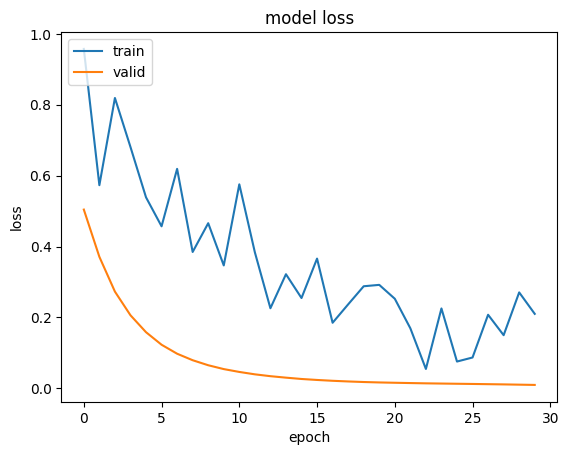

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
model = vit_classifier

In [ ]:
model.predict(x_test)

1/1 [==============================] - 0s 398ms/step


array([[0.628611  ],
       [0.59049916],
       [0.50580776],
       [0.6120158 ],
       [0.44475266],
       [0.44005406],
       [0.65555286],
       [0.5167428 ],
       [0.44145843],
       [0.44879347],
       [0.7413401 ],
       [0.60578644],
       [0.66665035],
       [0.667449  ],
       [0.6073542 ],
       [0.64412504]], dtype=float32)

In [ ]:
# Evaluating with test data
model = vit_classifier
print("Evaluate on test data")

loss, accuracy, f1_score = model.evaluate(x_test, y_test)

print(f"Test accuracy: {accuracy}")
print(f"Test loss: {loss}")
print(f"Test f1 score: {f1_score}")

Evaluate on test data
1/1 [==============================] - 0s 30ms/step - loss: 0.5367 - accuracy: 0.8750 - get_f1: 0.9231
Test accuracy: 0.875
Test loss: 0.5367337465286255
Test f1 score: 0.923076868057251
